In [ ]:
#IMPORTS

from typing import Tuple, Dict, Any, List
import os
from tkinter import Tk, filedialog, simpledialog, Toplevel, Button, Checkbutton, IntVar, Label, Frame
from tkinter.filedialog import askopenfilenames, askdirectory, asksaveasfilename

import cupy as cp
import geopandas as gpd
import hvplot.xarray
import ipywidgets as widgets
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np
import pandas as pd
import panel as pn
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
from rasterio.features import rasterize
import rasterio
from rasterio.warp import reproject, Resampling
from scipy import stats
from scipy.ndimage import generic_filter
from scipy.stats import mode
import shapely.geometry as sg
from shapely.geometry import box
import xarray as xr
import seaborn as sns

from IPython.display import display

from joblib import Parallel, delayed

import easygui

from CheckmateSample import make_checkerboard


In [ ]:
#CALCULATE GRID SIZE (from mask short edge)

# Function to compute grid size based on the mask file
def compute_grid_size(geojson_file: str, short_edge_cells: int = 20) -> Tuple[int, int]:
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(geojson_file)
    
    # Get the bounding box of the masking region
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Calculate width and height of the bounding box
    width = maxx - minx
    height = maxy - miny

    # Determine which is the short and long edge
    if width < height:
        short_edge = width
        long_edge = height
        orientation = 'portrait'
    else:
        short_edge = height
        long_edge = width
        orientation = 'landscape'

    # Compute the aspect ratio
    aspect_ratio = long_edge / short_edge

    # Compute the number of cells for the long edge
    long_edge_cells = int(short_edge_cells * aspect_ratio)

    # Determine the grid size based on the orientation
    if orientation == 'portrait':
        grid_size = (short_edge_cells, long_edge_cells)
    else:
        grid_size = (long_edge_cells, short_edge_cells)

    return grid_size

# Prompt the user for the short_edge_cells value using tkinter
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Ensure it is on top


# Ask the user for the short edge size
short_edge_cells = simpledialog.askinteger("Input", "Enter the number of cells for the short edge:", minvalue=1)

root.destroy()  # Close the tkinter root window

if short_edge_cells is None:
    raise ValueError("You must enter a valid number for the short edge size.")

# Set the mask file path
mask_file = r"C:\Users\TyHow\Documents\3. Work\GIS Stuff\ML_pilot_data\MASK.geojson"

# Compute grid size using the mask file
grid_size = compute_grid_size(mask_file, short_edge_cells=short_edge_cells)[::-1]
print(f"Calculated grid size: {grid_size}")


In [ ]:
#SELECT VECTOR FILES

# Function to interactively select files
def select_geojson_files():
    # Create a Tkinter root window (hidden)
    root = Tk()
    root.withdraw()  # Hide the main window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open the file selection dialog
    geojson_files = filedialog.askopenfilenames(
        title="Select GeoJSON Files",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )
    
    root.destroy()  # Close the root window after selection
    return list(geojson_files)  # Convert tuple to list and return

# Use the function to select files
geojson_files = select_geojson_files()

# Print the selected files for verification
print(f"Selected GeoJSON files: {geojson_files}")

#SELECT VECTOR FILE LAYERS
vector_features_to_process = []

def select_columns(geojson_file):
    """Function to display column selection widgets for a given GeoJSON file."""
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(geojson_file)
    
    # Get the list of columns
    columns = gdf.columns.tolist()
    
    # Create a multiple selection widget for columns
    selection = widgets.SelectMultiple(
        options=columns,
        description=f'Select columns for {os.path.basename(geojson_file)}:',
        rows=10
    )
    
    # Display the widget and button
    display(selection)

    # Define button click event
    def on_button_click(b):
        # For each selected column, create a tuple of (geojson_file, column_name)
        selected_columns = [(geojson_file, col) for col in selection.value]
        vector_features_to_process.extend(selected_columns)
        print(f'Selected columns from {geojson_file}: {selected_columns}')
    
    # Create and display button
    button = widgets.Button(description="Submit Selection")
    button.on_click(on_button_click)
    display(button)

# Iterate through each GeoJSON file and let the user select columns
for file in geojson_files:
    select_columns(file)

In [26]:
#VECTOR PROCESSING FUNCTIONS

def process_cell(idx, cell, gdf, sindex, feature_column, category_to_int):
    i, j = divmod(idx, grid_size[1])

    # Use the spatial index to find potential intersecting polygons
    possible_matches_index = list(sindex.intersection(cell.bounds))
    if not possible_matches_index:
        return i, j, np.nan  # Return NaN if no polygon is found

    possible_matches = gdf.iloc[possible_matches_index]
    if possible_matches.empty:
        return i, j, np.nan  # Return NaN if no polygon is found

    # For polygons, find intersections
    intersections = possible_matches.geometry.intersection(cell)
    valid_intersections = intersections[intersections.area > 0]

    if valid_intersections.empty:
        return i, j, np.nan

    if len(valid_intersections) > 5:
        areas_per_category = {}
        for idx, intersection in enumerate(valid_intersections):
            if not intersection.is_empty:
                category = possible_matches.iloc[idx][feature_column]
                # Use the raw category (no file name prefix)
                if category not in areas_per_category:
                    areas_per_category[category] = 0
                areas_per_category[category] += intersection.area

        if areas_per_category:
            max_category = max(areas_per_category, key=areas_per_category.get)
            return i, j, category_to_int[max_category]
        else:
            return i, j, np.nan
    else:
        largest_intersection_idx = valid_intersections.area.idxmax()
        category = possible_matches.loc[largest_intersection_idx, feature_column]
        # Use raw category here as well
        return i, j, category_to_int[category]


# Function to process each feature column
def process_feature_column(geojson_file, feature_column, grid_size, target_crs, x, y):
    gdf = gpd.read_file(geojson_file)
    print(f"Processing feature column: {feature_column} from file: {geojson_file}")

    gdf = gdf.to_crs(target_crs)
    if gdf.empty:
        print(f"GeoDataFrame for {geojson_file} is empty after reprojecting. Skipping column: {feature_column}")
        return None

    # Remove filename from category_to_int key and only use field names for values
    unique_categories = gdf[feature_column].unique()
    category_to_int = {cat: i for i, cat in enumerate(unique_categories)}

    grid = np.full(grid_size, np.nan)  # Create an empty grid filled with NaN
    sindex = gdf.sindex

    cells = [box(x[j], y[i], x[j + 1], y[i + 1])
             for i in range(grid_size[0])
             for j in range(grid_size[1])]

    results = Parallel(n_jobs=-1)(delayed(process_cell)(
        idx, cell, gdf, sindex, feature_column, category_to_int
    ) for idx, cell in enumerate(cells))

    if not results:
        print(f"No results were generated for feature column: {feature_column} from file: {geojson_file}")
        return None

    for i, j, value in results:
        grid[i, j] = value

    # Flip the grid vertically (along Y-axis)
    grid_flipped = np.flipud(grid)

    # Strip '.geojson' from the file name to clean up field names
    filename_cleaned = os.path.basename(geojson_file).replace('.geojson', '')
    return (f"{filename_cleaned}_{feature_column}", grid_flipped, category_to_int)


# Batch processing function
def geojson_to_numpy_grid_3d_batch(
    grid_size: Tuple[int, int],  # Grid size for the output array
    geojson_files: List[str],  # List of GeoJSON files
    features_to_process: List[Tuple[str, str]],  # List of (file, feature) tuples to process
    target_crs: str = "EPSG:3857"  # Web Mercator projection
) -> Tuple[np.ndarray, Dict[str, np.ndarray], Dict[str, Dict[Any, int]], List[Dict[str, Any]]]:
    all_feature_grids = {}
    all_feature_mappings = {}  # Initialize all_feature_mappings to track the category mappings
    geospatial_info_list = []

    results = []

    # Process each file and its corresponding features
    for geojson_file in geojson_files:
        # Get the filename without extension for prefixing the field names
        filename_prefix = os.path.basename(geojson_file).replace('.geojson', '').replace('.json', '')

        # Read the GeoJSON file to get the total bounds
        gdf = gpd.read_file(geojson_file)
        gdf = gdf.to_crs(target_crs)
        minx, miny, maxx, maxy = gdf.total_bounds

        x = np.linspace(minx, maxx, grid_size[1] + 1)
        y = np.linspace(miny, maxy, grid_size[0] + 1)

        # Extract relevant features for this file
        file_features = [feature for file, feature in features_to_process if file == geojson_file]

        # Store geospatial information for each file
        geospatial_info = {
            'transform': (minx, miny, maxx, maxy),
            'crs': target_crs,
            'file_name': filename_prefix
        }
        geospatial_info_list.append(geospatial_info)

        # Use joblib to parallelize the processing of each feature column
        results.extend(Parallel(n_jobs=-1)(delayed(process_feature_column)(
            geojson_file, feature_column, grid_size, target_crs, x, y
        ) for feature_column in file_features))

    for feature_name, grid, category_to_int in results:
        all_feature_grids[feature_name] = grid
        all_feature_mappings[feature_name] = category_to_int  # Store category mappings for each feature

    grid_3d = np.stack(list(all_feature_grids.values()), axis=0)

    return grid_3d, all_feature_grids, all_feature_mappings, geospatial_info_list


In [ ]:
#SELECT/PROCESS RASTERS

#to defined grid with feature mappings

# Get the bounding box of the mask file to use for target transform
raster_gdf = gpd.read_file(mask_file)
minx, miny, maxx, maxy = raster_gdf.total_bounds

# Convert the GeoDataFrame to a projected CRS
raster_gdf = raster_gdf.to_crs("EPSG:4326")  # Project to a common projected CRS, e.g., EPSG:3857

# Recalculate bounds in the projected CRS
minx, miny, maxx, maxy = raster_gdf.total_bounds

# Compute the target transform for the projected CRS
raster_target_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])
raster_target_crs = "EPSG:4326"  # Set the target CRS to a projected coordinate system

# Open a file selection dialog for the user to select multiple raster files
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Bring the dialog to the front

# Open the file selection dialog
raster_files = askopenfilenames(
    title="Select Raster Files",
    filetypes=[("GeoTIFF files", "*.tif"), ("All files", "*.*")]
)

# Lists to store data and corresponding file names
raster_data = []
raster_names = []
raster_feature_mappings = []  # List to store the mappings from filenames to their corresponding layers

# Now, reproject and resample each raster to the common grid
for layer_index, raster_file in enumerate(raster_files):
    with rasterio.open(raster_file, 'r') as src:
        print(f"Processing file: {raster_file}")
        print(f"Source CRS: {src.crs}")
        print(f"Source Transform: {src.transform}")
        print(f"Source Bounds: {src.bounds}")

        # Check if the source CRS matches the target CRS; reproject if needed
        if src.crs != raster_target_crs:
            src_crs = src.crs
        else:
            src_crs = raster_target_crs  # Keep the same CRS if already matching
        
        # Prepare the output array with NaN (representing no data)
        raster_data_array = np.full(grid_size, np.nan, dtype=np.float32)

        # Handle NoData value
        nodata_value = src.nodata
        if nodata_value is None:
            nodata_value = np.nan  # If NoData is not set, assume NaN

        # Print debug information
        print(f"Reprojecting {raster_file} to target grid...")
        print(f"Target CRS: {raster_target_crs}")
        print(f"Target Transform: {raster_target_transform}")
        print(f"Target Grid Size: {grid_size}")

        # Reproject the source data to the target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=raster_data_array,
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=raster_target_transform,
            dst_crs=raster_target_crs,
            resampling=Resampling.nearest,
            src_nodata=nodata_value,
            dst_nodata=np.nan  # Use NaN as the destination NoData
        )

        # Append the resampled data and names to lists
        raster_data.append(raster_data_array)  # Append the resampled data array
        file_name = os.path.basename(raster_file).replace('.tiff', '').replace('.tif', '')
        raster_names.append(file_name)

        # Append the filename to feature mappings with its corresponding layer index
        raster_feature_mappings.append((file_name, layer_index))

# Stack list into a 3D numpy array
raster_data = np.stack(raster_data, axis=0)  # Stack the list of arrays into a 3D numpy array
print(raster_data.shape, raster_names)
print("Feature Mappings:", raster_feature_mappings)  # Print the feature mappings

# Check if all data layers contain NaN
for i in range(raster_data.shape[0]):
    print(f"Layer {i} ({raster_names[i]}):")
    if np.all(np.isnan(raster_data[i])):
        print("  All values are NaN.")
    else:
        print(f"  Min value: {np.nanmin(raster_data[i])}")
        print(f"  Max value: {np.nanmax(raster_data[i])}")


In [18]:
#POIS

POI_file = r"C:\Users\TyHow\Documents\3. Work\GIS Stuff\ML_pilot_data\M162-Deposits_CLIPPED.geojson"

POI_df = gpd.read_file(POI_file)
POI_df_projected = POI_df.to_crs("EPSG:3857")  # UTM or other projected CRS to allow buffering

#POI_df_projected.plot()

# Store original geometries to reset them
POI_df_original = POI_df_projected.copy()  # Keep a copy of the original point geometries

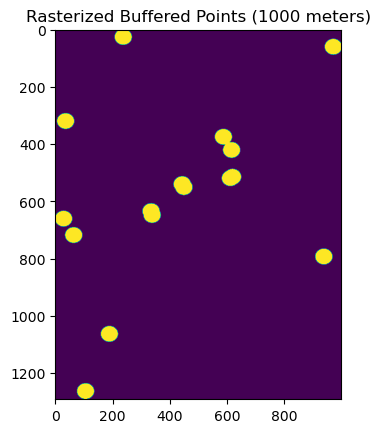

In [20]:
#BUFFER/RASTERIZE POINTS

# Function to apply buffer and rasterize
def buffer_and_rasterize(POI_buffer_size, grid_size):
    # Reset geometries to the original point form by creating a fresh copy each time
    POI_df_projected_reset = POI_df_original.copy(deep=True)
    
    # Buffer the points by the specified buffer size (in meters)
    POI_df_projected_reset['geometry'] = POI_df_projected_reset.geometry.buffer(POI_buffer_size)

    # Create the transform and grid size
    bounds = POI_df_projected_reset.total_bounds
    POI_transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], grid_size[1], grid_size[0])

    # Rasterize the buffered points, setting the value of points to 1, others to 0
    POI_geometry_generator = ((geom, 1) for geom in POI_df_projected_reset.geometry)
    POI_data = rasterize(shapes=POI_geometry_generator, out_shape=grid_size, fill=0, transform=POI_transform).astype('float32')

    # Display the rasterized points
    plt.imshow(POI_data)
    plt.title(f'Rasterized Buffered Points ({POI_buffer_size} meters)')
    plt.show()

# Example usage
POI_buffer_size = 1000  # Set your buffer size here
buffer_and_rasterize(POI_buffer_size, grid_size)

In [ ]:
#PROCESS VECTORS


vector_data, vector_feature_grids, all_feature_mappings, vector_geospatial_info_list = geojson_to_numpy_grid_3d_batch(
    grid_size, geojson_files, vector_features_to_process
)

# Print results
print("Shape of the 3D grid array:", vector_data.shape)
print("Feature grids:", vector_feature_grids.keys())
print("Feature mappings:", all_feature_mappings)
print("Geospatial information for each file:", vector_geospatial_info_list)


In [ ]:
#SIMPLE SLIDER PLOT

data_to_plot = POI_data

# Initialize the Panel extension
pn.extension()

# Function to plot a specific layer using Matplotlib
def plot_layer_bokeh(layer_index):
    # Create the plot
    fig = Figure(figsize=(3, 4))
    ax = fig.add_subplot(111)
    ax.imshow(data_to_plot[layer_index], cmap='viridis', interpolation='nearest', aspect='auto')
    ax.set_title(f"Layer {layer_index + 1}")
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    return pn.pane.Matplotlib(fig, tight=True)

# Create a Bokeh slider widget for selecting the layer
layer_slider = pn.widgets.IntSlider(name='Layer Index', start=0, end=data_to_plot.shape[0] - 1, step=1, value=0)

# Bind the plotting function to the slider value
panel = pn.bind(plot_layer_bokeh, layer_index=layer_slider)

# Display the Panel with the slider and plot
pn.Column(layer_slider, panel).servable()


In [ ]:
#SAVE RASTER DATA

# Hide the root window for file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a folder to save the files
output_directory = askdirectory(
    initialdir=r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports",
    title="Select a Folder to Save Output Files (BEWARE OVERWRITE!)"
)

if output_directory:
    # Construct file paths using the selected folder and default file names
    output_6_rasters_file = os.path.join(output_directory, "output_rasters.npy")
    output_6_rasters_layer_mappings_file = os.path.join(output_directory, "output_rasters_layer_mappings.npy")

    # Save the files
    np.save(output_6_rasters_file, raster_data)
    np.save(output_6_rasters_layer_mappings_file, raster_feature_mappings)

    print(f"Files saved in: {output_directory}")

# Destroy the root window after file dialogs are closed
root.destroy()

In [ ]:
#SAVE VECTOR DATA

# Hide the root window for file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a folder to save the files
output_directory = askdirectory(
    initialdir=r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports",
    title="Select a Folder to Save Output Files (BEWARE OVERWRITE!)"
)

if output_directory:
    # Construct file paths using the selected folder and default file names
    output_array_file = os.path.join(output_directory, "output_vectors.npy")
    output_feature_grid_file = os.path.join(output_directory, "output_vector_feature_grid.npy")
    output_feature_mappings_file = os.path.join(output_directory, "output_vector_feature_mappings.npy")
    output_geospatial_info_file = os.path.join(output_directory, "output_vector_geospatial_info.npy")

    # Save the files
    np.save(output_array_file, vector_data)
    np.save(output_feature_grid_file, vector_feature_grids)
    np.save(output_feature_mappings_file, all_feature_mappings)
    np.save(output_geospatial_info_file, vector_geospatial_info_list)

    print(f"Files saved in: {output_directory}")

# Destroy the root window after file dialogs are closed
root.destroy()


In [ ]:
# IMPORT NETCDF AS ARRAY

# Function to prompt the user to select a .nc file
def select_nc_file():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open a file selection dialog
    file_path = filedialog.askopenfilename(
        title="Select NetCDF File",
        filetypes=[("NetCDF files", "*.nc"), ("All files", "*.*")]
    )

    root.destroy()  # Close the root window after file selection
    
    return file_path

# Function to convert a NetCDF file to a NumPy array
def nc_to_numpy(file_path):
    try:
        # Load the NetCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Display available variables
        print("Variables available in the NetCDF file:")
        for var in ds.data_vars:
            print(var)
        
        # Select the variable to convert to NumPy array (adjust as needed)
        var_name = input("Enter the variable name to convert to NumPy array: ")

        if var_name in ds:
            # Extract the variable and convert it to a NumPy array
            data_array = ds[var_name].values
            print(f"Successfully converted {var_name} to a NumPy array with shape {data_array.shape}")
            return data_array
        else:
            print(f"Variable '{var_name}' not found in the NetCDF file.")
            return None

    except Exception as e:
        print(f"Error loading NetCDF file: {e}")
        return None

# Step 1: Select the NetCDF file
selected_file = select_nc_file()

if selected_file:
    print(f"Selected file: {selected_file}")
    
    # Step 2: Convert the selected NetCDF file to a NumPy array
    nc_array = nc_to_numpy(selected_file)
    
    if nc_array is not None:
        print(f"Converted NumPy array shape: {nc_array.shape}")
else:
    print("No file selected.")


In [4]:
#REPLACE combined_data WITH IMPORTED .NC ARRAY
combined_data = nc_array

In [ ]:
# COMBINE ARRAYS - WITH LAYER NAMES

# Combine the arrays (vector and raster)
if vector_data.shape[1:] == raster_data.shape[1:]:
    combined_data = np.concatenate((vector_data, raster_data), axis=0)
    print(f"Combined array shape: {combined_data.shape}")

    # Initialize the layer name mapping list
    combined_layer_names = []

    # Add vector layer names (from feature names in vector_feature_grids) first
    for vector_feature_name in vector_feature_grids.keys():
        combined_layer_names.append(vector_feature_name)

    # Add raster layer names (from file names) after the vector layer names
    for raster_name in raster_names:
        combined_layer_names.append(raster_name)

    # Check the mapping to ensure it is correct
    print("Layer Name Mapping List:", combined_layer_names)

    # Ensure the combined_data layers match the number of names
    if len(combined_layer_names) == combined_data.shape[0]:
        print(f"Layer name mapping successful. Total layers: {len(combined_layer_names)}")
    else:
        print(f"Warning: Mismatch in layers. {len(combined_layer_names)} names for {combined_data.shape[0]} layers.")
else:
    print("Error: The x/y dimensions of the arrays do not match.")


In [ ]:
#PLOT COMBINED - with layer names

data_to_plot = combined_data

# Initialize the Panel extension
pn.extension()

# Assuming combined_layer_names is a list that stores the names of each layer
# combined_layer_names should be the list that maps to each layer of the combined_data array

# Function to plot a specific layer using Matplotlib
def plot_layer_bokeh(layer_index):
    # Create the plot
    fig = Figure(figsize=(3, 4))
    ax = fig.add_subplot(111)
    ax.imshow(data_to_plot[layer_index], cmap='viridis', interpolation='nearest', aspect='auto')
    
    # Use combined_layer_names for the title
    ax.set_title(f"Layer {layer_index + 1}: {combined_layer_names[layer_index]}")
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    return pn.pane.Matplotlib(fig, tight=True)

# Create a Bokeh slider widget for selecting the layer
layer_slider = pn.widgets.IntSlider(name='Layer Index', start=0, end=data_to_plot.shape[0] - 1, step=1, value=0)

# Bind the plotting function to the slider value
panel = pn.bind(plot_layer_bokeh, layer_index=layer_slider)

# Display the Panel with the slider and plot
pn.Column(layer_slider, panel).servable()


In [12]:
# CONVERT TO XARRAY

# Create dummy arrays for X, Y coordinates (you can replace these with your actual coordinates)
x_coords = np.arange(combined_data.shape[2])  # X-coordinates (along the third axis)
y_coords = np.arange(combined_data.shape[1])  # Y-coordinates (along the second axis)
layer_names = combined_layer_names  # Layer names

# Create an xarray DataArray from the combined NumPy array
data_xr = xr.DataArray(
    combined_data, 
    dims=["layer", "y", "x"], 
    coords={"layer": layer_names, "y": y_coords, "x": x_coords},
    name="combined_layers"
)


In [ ]:
#EXPORT XARRAY TO NETCDF

# Hide the root window for the file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a location to save the NetCDF file
output_file = asksaveasfilename(
    initialfile="THE_CUBE.nc",  # Default file name
    defaultextension=".nc",  # Default extension
    filetypes=[("NetCDF files", "*.nc"), ("All files", "*.*")],
    title="Save NetCDF file"
)

# If the user provides a location, save the NetCDF file
if output_file:
    data_xr.to_netcdf(output_file)
    print(f"Data successfully exported to {output_file}")

# Destroy the root window after file dialog is closed
root.destroy()

In [14]:
# DEFINE CHECKERBOARD FUNCTION
def checkerboard_data(data: np.ndarray, points_of_interest: np.ndarray, square_size: tuple[int, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Apply checkerboard pattern to the data and split into two sets (checker 0 and checker 1).
    
    Parameters:
        data (np.ndarray): The 3D data array (layers, y, x).
        points_of_interest (np.ndarray): The 2D binary array corresponding to points of interest (y, x).
        square_size (tuple[int, int]): Size of each checkerboard square.
    
    Returns:
        X_check0, y_check0, X_check1, y_check1: Checkerboarded and NaN-removed datasets.
    """
    # Check dimensions to ensure the spatial dimensions of data and points_of_interest match
    if points_of_interest.shape != (data.shape[1], data.shape[2]):
        raise ValueError("Points of interest and data spatial dimensions (y, x) do not match.")
    
    # Flatten spatial dimensions of the data for easier manipulation
    X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
    y_pix = points_of_interest.flatten()

    # Debug: Print data shapes after reshaping
    print(f"X_pix shape: {X_pix.shape}")
    print(f"y_pix shape: {y_pix.shape}")

    # Remove NaNs from the points_of_interest and corresponding data
    X = X_pix[~np.isnan(y_pix)]
    y = y_pix[~np.isnan(y_pix)]

    print(f"Shape of data after removing NaNs (X): {X.shape}")
    print(f"Shape of points of interest after removing NaNs (y): {y.shape}")

    # Create checkerboard pattern
    checker = make_checkerboard((data.shape[1], data.shape[2]), square_size)

    # Debug: Print checkerboard shape and flattened shape
    print(f"Checkerboard shape: {checker.shape}")
    print(f"Checkerboard flattened shape: {checker.flatten().shape}")

    # Split data based on checkerboard pattern
    X_check0 = X_pix[checker.flatten() == 0]
    y_check0 = y_pix[checker.flatten() == 0]

    X_check1 = X_pix[checker.flatten() == 1]
    y_check1 = y_pix[checker.flatten() == 1]

    # Debug: Print shapes of split data
    print(f"Checker 0 data shape: {X_check0.shape}, Checker 1 data shape: {X_check1.shape}")
    print(f"Checker 0 labels shape: {y_check0.shape}, Checker 1 labels shape: {y_check1.shape}")

    # Remove NaNs from each checker set
    X_check0 = X_check0[~np.isnan(y_check0)]
    y_check0 = y_check0[~np.isnan(y_check0)]

    X_check1 = X_check1[~np.isnan(y_check1)]
    y_check1 = y_check1[~np.isnan(y_check1)]

    # Print final details
    print(f'\nChecker 0: X data array shape is {X_check0.shape}, y points of interest array shape is {y_check0.shape}')
    print(f'Checker 1: X data array shape is {X_check1.shape}, y points of interest array shape is {y_check1.shape}')

    return X_check0, y_check0, X_check1, y_check1

In [ ]:
# TEST GENERATE CHECKERBOARD
board_size = (combined_data.shape[1], combined_data.shape[2])  # Adjust based on the size of your data grid (y, x)
square_size = (200, 200)   # Size of the checkerboard squares

checker = make_checkerboard(board_size, square_size)
print(checker)  # Print the checkerboard pattern
print(np.unique(checker.flatten()))  # This should return [0, 1]

plt.imshow(checker)

In [ ]:
# CHECKER DATA
target_layer = 4
square_size = (200, 200)   # Size of the checkerboard squares

points_of_interest = combined_data[target_layer]
X_check0, y_check0, X_check1, y_check1 = checkerboard_data(combined_data, points_of_interest, square_size)

# After running the function, check the output
print(f'Checker 0: X data array shape is {X_check0.shape}, y points of interest array shape is {y_check0.shape}')
print(f'Checker 1: X data array shape is {X_check1.shape}, y points of interest array shape is {y_check1.shape}')



In [28]:
# CREATE DATAFRAMES FUNCTION

def create_dataframes(combined_data: np.ndarray, X_check0: np.ndarray, y_check0: np.ndarray, 
                      X_check1: np.ndarray, y_check1: np.ndarray, combined_layer_names: list, 
                      all_feature_mappings: Dict[str, Dict[Any, int]], target_layer: int) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Create 3 pandas DataFrames based on combined_data and checkerboard data:
    1) Complete DataFrame with categories converted back from integer values for categorical layers,
       and the target layer removed.
    2) Checkerboard 0 DataFrame with categories converted back from integer values for categorical layers,
       and including the target layer.
    3) Checkerboard 1 DataFrame with categories converted back from integer values for categorical layers,
       and including the target layer.
    
    Parameters:
        combined_data (np.ndarray): The complete 3D array of data (layers, y, x).
        X_check0 (np.ndarray): The checkerboard 0 data array (including the target).
        y_check0 (np.ndarray): The target data for checkerboard 0.
        X_check1 (np.ndarray): The checkerboard 1 data array (including the target).
        y_check1 (np.ndarray): The target data for checkerboard 1.
        combined_layer_names (list): The list of layer names in the order they appear in combined_data.
        all_feature_mappings (Dict[str, Dict[Any, int]]): The mapping of categorical data to integers.
        target_layer (int): The index of the target layer to be removed from the complete DataFrame.
        
    Returns:
        complete_df_with_categories (pd.DataFrame): The complete DataFrame with categories converted back,
                                                    and without the target layer.
        checker0_df_with_categories (pd.DataFrame): The checkerboard 0 DataFrame with categories converted back,
                                                    and with the target layer included.
        checker1_df_with_categories (pd.DataFrame): The checkerboard 1 DataFrame with categories converted back,
                                                    and with the target layer included.
    """
    
    # 1. Complete DataFrame with categories converted back, and the target layer removed
    # Remove the target layer from combined_data
    data_no_target = np.delete(combined_data, target_layer, axis=0)
    layer_names_no_target = [name for i, name in enumerate(combined_layer_names) if i != target_layer]

    data_no_target_flattened = data_no_target.reshape(data_no_target.shape[0], -1).T  # Flatten the spatial dims
    complete_df_with_categories = pd.DataFrame()

    # Loop through each layer (excluding the target) and check if it's categorical
    for layer_idx, layer_name in enumerate(layer_names_no_target):
        if layer_name in all_feature_mappings:
            # Reverse the integer-to-category mapping
            int_to_category = {v: k for k, v in all_feature_mappings[layer_name].items()}
            # Map the flattened integer data back to categories
            complete_df_with_categories[layer_name] = pd.Series(data_no_target_flattened[:, layer_idx]).map(int_to_category)
        else:
            # If the layer is numerical, just add it to the DataFrame as is
            complete_df_with_categories[layer_name] = data_no_target_flattened[:, layer_idx]

    print(f"Complete DataFrame with categories (no target) shape: {complete_df_with_categories.shape}")

    # 2. Checkerboard 0 DataFrame (data already includes the target)
    checker0_df_with_categories = pd.DataFrame()

    for layer_idx, layer_name in enumerate(combined_layer_names):
        if layer_name in all_feature_mappings:
            # Reverse the integer-to-category mapping
            int_to_category = {v: k for k, v in all_feature_mappings[layer_name].items()}
            # Map the checker0 integer data back to categories
            checker0_df_with_categories[layer_name] = pd.Series(X_check0[:, layer_idx]).map(int_to_category)
        else:
            # If the layer is numerical, just add it to the DataFrame as is
            checker0_df_with_categories[layer_name] = X_check0[:, layer_idx]

    print(f"Checkerboard 0 DataFrame with categories shape: {checker0_df_with_categories.shape}")

    # 3. Checkerboard 1 DataFrame (data already includes the target)
    checker1_df_with_categories = pd.DataFrame()

    for layer_idx, layer_name in enumerate(combined_layer_names):
        if layer_name in all_feature_mappings:
            # Reverse the integer-to-category mapping
            int_to_category = {v: k for k, v in all_feature_mappings[layer_name].items()}
            # Map the checker1 integer data back to categories
            checker1_df_with_categories[layer_name] = pd.Series(X_check1[:, layer_idx]).map(int_to_category)
        else:
            # If the layer is numerical, just add it to the DataFrame as is
            checker1_df_with_categories[layer_name] = X_check1[:, layer_idx]

    print(f"Checkerboard 1 DataFrame with categories shape: {checker1_df_with_categories.shape}")

    return complete_df_with_categories, checker0_df_with_categories, checker1_df_with_categories





In [ ]:
# GENERATE DATAFRAMES

# Create the dataframes
complete_df, checker0_df, checker1_df = create_dataframes(
    combined_data, X_check0, y_check0, X_check1, y_check1, combined_layer_names, all_feature_mappings, target_layer
)

# Print out the first few rows to check
print(complete_df.head())
print(checker0_df.head())
print(checker1_df.head())


In [ ]:
#EXPORT DFS PARQUET

import pandas as pd
import tkinter as tk
from tkinter import filedialog
import os

# Function to prompt the user for an output directory
def select_output_directory():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front
    output_dir = filedialog.askdirectory(title="Select Output Directory")
    root.destroy()
    return output_dir

# Export DataFrames to Parquet files in the selected directory
def export_dfs_to_parquet(checker0_df: pd.DataFrame, checker1_df: pd.DataFrame, complete_df: pd.DataFrame):
    output_dir = select_output_directory()
    if not output_dir:
        print("No directory selected. Exiting...")
        return
    
    # File paths for each DataFrame
    checker0_file = os.path.join(output_dir, 'checker0_df.parquet')
    checker1_file = os.path.join(output_dir, 'checker1_df.parquet')
    complete_file = os.path.join(output_dir, 'complete_df.parquet')

    # Save DataFrames to Parquet format
    checker0_df.to_parquet(checker0_file, engine='pyarrow')
    checker1_df.to_parquet(checker1_file, engine='pyarrow')
    complete_df.to_parquet(complete_file, engine='pyarrow')
    
    print(f"DataFrames saved to directory: {output_dir}")

# Example usage assuming checker0_df, checker1_df, and complete_df are already generated
export_dfs_to_parquet(checker0_df, checker1_df, complete_df)


In [ ]:
#INSPECT DF
pd.set_option('display.max_rows', 10) 
#checker1_df['M162-Deposits_CLIPPED_fid']
complete_df

In [ ]:
#PAIRPLOT TO COMPARE CHECK0/1

def generate_multidimensional_pairplot_for_checker_data(checker0_df: pd.DataFrame, checker1_df: pd.DataFrame):
    """
    Generate a multidimensional seaborn pairplot comparing Checkerboard 0 and Checkerboard 1 DataFrames,
    focusing on numerical columns only.
    
    Parameters:
        checker0_df (pd.DataFrame): DataFrame for Checkerboard 0.
        checker1_df (pd.DataFrame): DataFrame for Checkerboard 1.
    """
    # Add a column to each DataFrame indicating which checkerboard it belongs to
    checker0_df['Checkerboard'] = 'Checkerboard 0'
    checker1_df['Checkerboard'] = 'Checkerboard 1'

    # Combine the two DataFrames
    combined_df = pd.concat([checker0_df, checker1_df], ignore_index=True)

    # Check which layers are available for plotting
    print(f"Columns available in combined DataFrame: {combined_df.columns}")

    # Filter out non-numerical (categorical) columns
    numerical_columns = combined_df.select_dtypes(include=['number']).columns.tolist()

    # Create the pairplot with hue based on 'Checkerboard'
    sns.pairplot(combined_df, vars=numerical_columns, hue='Checkerboard', diag_kind='kde', palette="Set2", markers=["o", "s"], height=2.5)

    # Show the plot
    plt.show()

# Example usage:
generate_multidimensional_pairplot_for_checker_data(checker0_df, checker1_df)
